# RL homework 1
**Due date: March 2nd, 2021, 11am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: Philip Redford-Jones

Student number: 14017791

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms (without running experiments or extensive calculations)

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [1]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[8 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name

    # Initialise Q value for each action (arm)
    self.Q = np.zeros(self._number_of_arms)
    # Set bonus multiplier
    self.c = bonus_multiplier
    # Set the action count for each action (using ones to stop divide by 0 error)
    self.action_count = np.zeros(self._number_of_arms)
    # Set the total number of time step counter
    self.t = 1

    self.reset()

  def step(self, previous_action, reward):
    """Returns an action selected using Upper-Confidence Bound

    Input previous_action: the action selected at t-1
    Input reward: the reward for previous action

    Update Q(a): Updates the Q value for previous action given reward 

    Output action: action for the next step
    """

    # Update Q, action count
    if previous_action != None:
      self.action_count[previous_action] += 1
      self.Q[previous_action] = self.Q[previous_action] + (1 / self.action_count[previous_action]) * (reward - self.Q[previous_action])


    # Any previously unselected action should be selcted prior to selecting another action again
    if np.any(self.action_count == 0):
      # Select non-explored action
      action = np.random.choice(np.where(self.action_count == 0)[0])
    else:
      # Select new action
      upper_bound = self.Q + self.c * np.sqrt(np.log(self.t) / self.action_count)
      action = np.random.choice(np.where(upper_bound==upper_bound.max())[0])

    # Incement time step      
    self.t += 1

    return action

  def reset(self):
    """ Resets the agent statistics to the original values
    """

    # Initialise Q value for each action (arm)
    self.Q = np.zeros(self._number_of_arms)
    # Set the action count for each action (using ones to stop divide by 0 error)
    self.action_count = np.zeros(self._number_of_arms)
    # Set the total number of time step counter
    self.t = 1
    

In [7]:
# TEST CELL
# test_agent = UCB("UCB", 5, bonus_multiplier=(1/np.sqrt(2)))
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))

## Q2
**[8 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [8]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self.name = name
    self._number_of_arms = number_of_arms

    # Initialise Q value for each action (arm)
    self.Q = np.zeros(self._number_of_arms)
    # Set number of steps
    self.t = 1
    # Set epsilon value
    self.epsilon = epsilon
    # Set action count
    self.action_count = np.zeros(self._number_of_arms)

    self.reset()


  def step(self, previous_action, reward):
    """Returns an action selected using epsilon-greedy approach

    Input previous_action: the action selected at t-1
    Input reward: the reward for previous action

    Update Q(a): Updates the Q value for previous action given reward 

    Output action: action for the next step
    """

    # Update Q for previous action
    if previous_action is not None:
      # Update action count
      self.action_count[previous_action] += 1
      # Update Q value
      self.Q[previous_action] = self.Q[previous_action] +  (1 / self.action_count[previous_action]) * (reward - self.Q[previous_action])

    # Check if epsilon is scaler or callable
    if np.isscalar(self.epsilon):
      temp_epsilon = self.epsilon
    else: 
      temp_epsilon = self.epsilon(self.t)
    
    # Check if less than epsilon
    if np.random.random() < temp_epsilon:
      # Pick random action is less than epsilon
      action = np.random.randint(0, high=self._number_of_arms)
    else: 
      # Else pick the highest Q value
      action = np.random.choice(np.where(self.Q == self.Q.max())[0])

    # Increment time step
    self.t += 1

    return action

  def reset(self):
    """ Resets the agent statistics to the original values
    """
        
    # Initialise Q value for each action (arm)
    self.Q = np.zeros(self._number_of_arms)
    # Set number of steps
    self.t = 1
    # Set action count
    self.action_count = np.zeros(self._number_of_arms)

In [9]:
# Test cell

# test_agent = EpsilonGreedy("e-greedy", 5, epsilon=0.)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))

# test_agent = EpsilonGreedy("e-greedy", 5, epsilon=0.1)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))

# test_agent = EpsilonGreedy("e-greedy", 5, epsilon=lambda t: 1./t)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))

# test_agent = EpsilonGreedy("e-greedy", 5, epsilon=lambda t: 1./t**0.5)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))


## Q3
**[12 pts]** Implement a softmax REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [10]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self.name = name

    # Initialise the baseline as the average reward
    self.baseline = baseline
    # Average reward
    self.average_reward = 0
    # Initialise action preferences for each action (arm)
    self.p = np.ones(self._number_of_arms)
    # Set number of steps
    self.t = 1
    # Init the learning rate
    self.step_size = step_size
    # Init policy
    self.pi = self.square_max(self.p)

    self.reset()

  
  def square_max(self, p):
    """ Returns the square max policy for each action a
    Input p: number of arms dimensional array 
    """
    pi = (p ** 2) / (np.sum(p ** 2))
    return pi

  def step(self, previous_action, reward):
    
    # Update the baseline if using:
    if reward != None and self.baseline is True:
      # Update the baseline average reward
      self.average_reward += self.step_size * (reward - self.average_reward)

    # Update parameters
    if previous_action is not None:
      # Indicator function for selected actions, with 0's elsewhere
      temp_mask = np.zeros(number_of_arms)
      temp_mask[previous_action] = 1
      # Update for action preferences
      self.p += 2 * self.step_size * (reward - self.average_reward) * ((temp_mask / self.p[previous_action]) - (self.p / np.sum(self.p ** 2)))

    # Update policy
    self.pi = self.square_max(self.p)

    # Select action using random choice based on policy
    action = np.random.choice(self._number_of_arms, p=self.pi)

    # Increment time step
    self.t += 1

    return action

  def reset(self):
    
    # Average reward
    self.average_reward = 0
    # Initialise action preferences for each action (arm)
    self.p = np.ones(self._number_of_arms)
    # Set number of steps
    self.t = 1
    # Init policy
    self.pi = self.square_max(self.p)

In [11]:
# Test cell

# test_agent = REINFORCE("REINFORCE", 5, step_size=0.25, baseline=True)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))


# test_agent = REINFORCE("REINFORCE", 5, step_size=0.24, baseline=False)
# action = test_agent.step(None, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))
# action = test_agent.step(action, np.random.randint(0, 2))

The above uses the update rule: 

$$
  p(a) = p(a) + 2 \alpha (R - \bar{R}) \left(\frac{I_{A_t=a}}{p(a)} - \frac{p(a)}{\sum_b{p(b)^2}}\right)
$$

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [12]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

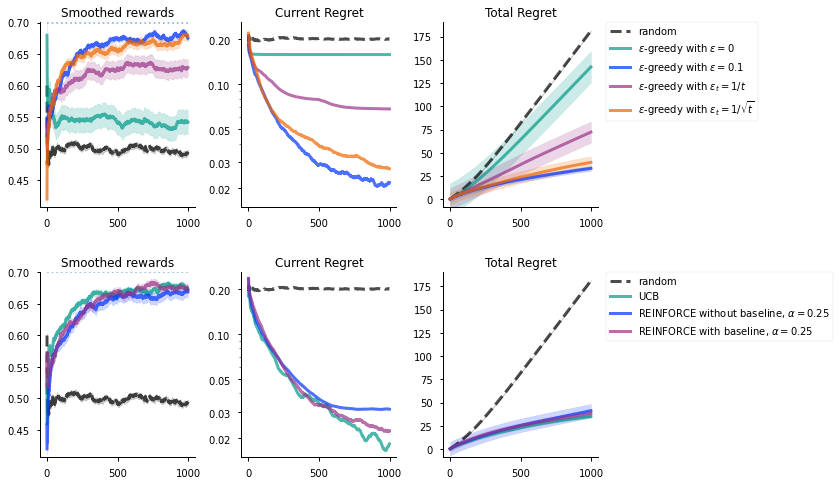

In [13]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best two algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

The best algorithms on average are UCB and REINFORCE with baseline. Sometimes $\epsilon$-greedy with $\epsilon=0.1$ or $\epsilon=1/\sqrt{t}$ perform comparably well, and are guaranteed to converge to the optimal value $q^*$ given infinite timesteps. But they take longer to converge in general than UCB and REINFORCE, with baseline leading to a higher total regret.

In the non-stationary case, we may expect $\epsilon=0.1$ to perform better than UCB depending on the changing conditions, but restricting the discussion to the stationary case, we can see that UCB and REINFORCE with baseline will generally perform better. 

The main benefits to using UCB and REINFORCE are that they incorporate prior knowledge of the value distribution when exploring. This contrasts to $\epsilon$-greedy, which explores randomly when not exploiting. 

Assuming that the rewards are the same for all actions, with the only difference coming in the reward payout probabilities, UCB will initially select all actions and continue to choose the actions with the highest average reward. It will also choose actions that it has selected less frequently and is less confident in its expected reward prediction. This targeted exploration approach vastly speeds up convergence to the optimal policy, particularly in a large action space where random policies will continue to explore low reward options.

Similarly, REINFORCE improves convergence by exploring based on action preferences, thus exploring actions with low expected rewards but less frequently. Adding in a baseline to REINFORCE generally further improves the approach by comparing the action reward to the expected reward and decreasing the preference if the reward is lower than expected. The non-selected action moves in the opposite direction, meaning the relative likelihood of selecting this poor action is decreased. Similarly, if the action gives a higher reward than the expected reward, the relative preference is updated positively. Without this baseline, rewards that are lower than average but higher than the previously predicted reward for this action would shift the action preference higher, even though this is still a worse action selection than others. 

There are some unlikely scenarios where we may expect UCB and REINFORCE with baseline to perform worse. For example, in an environment with unequal payouts and a small number of actions, an action with a low probability of payout but disproportionately high rewards may be quickly ruled out by UCB or REINFORCE but randomly selected more often leading to reward by $\epsilon$-greedy. This somewhat contrived example shows that there are scenarios where $\epsilon$-greedy can outperform the others. But in general, we would expect UCB and REINFORCE with baseline to converge to the optimal $q^*$ fastest, minimising the total regret. 

**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.

The worst performing approach is $\epsilon=0$ as this essentially leaves no option for exploration, and is a pure exploitation approach. This approach means that the first action that gives a non-zero reward will be selected continuously from that point. There is a small probability that the initially selected action could be the optimal action, but this is unlikely and becomes less likely as the number of actions increases.  

The 2nd worst approach for this problem is $\epsilon=1/t$ where t is the time step. This approach improves on a pure greedy approach by allowing early exploration. Early exploration of actions allows the agent to build up a more accurate picture of which action produce a high reward. The issue with this approach, though is that epsilon decays too quickly to explore the actions well. For example, after just 20-time steps $\epsilon=0.05$ meaning it is improbable to select an action with a low Q value. 

$\epsilon=0.1$ improves this by allowing continued exploration throughout training, allowing the agent to build up an accurate model of the expected rewards for each action. $\epsilon=1/\sqrt{t}$ improves this further by enabling a slow decay of the epsilon value for higher early exploration of all actions. After this early exploration stage, the agent converges on the actions with a high expected reward as $\epsilon$ decays to a small value. 

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [14]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

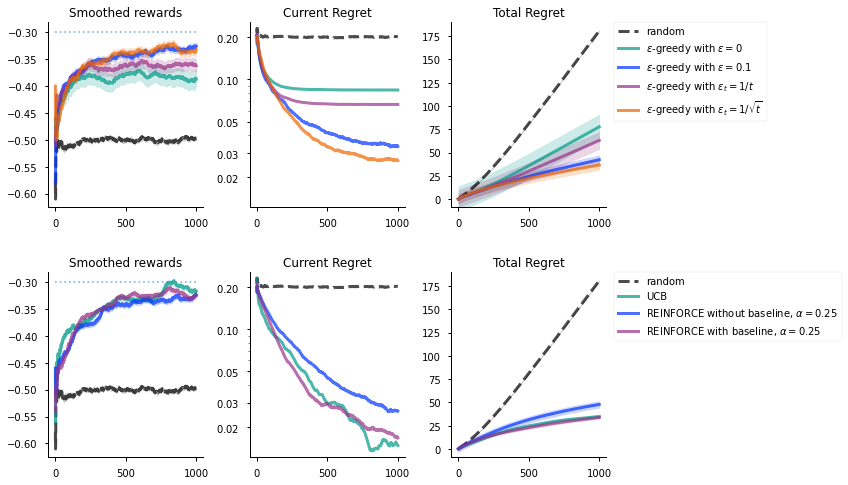

In [15]:
experiment2.show()

## Q6
**[8pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

$\epsilon$-greedy with $\epsilon=1/\sqrt(t)$: This approach continues to perform nicely with early exploration enabling the algorithm to identify the high reward actions. The early exploration is independent of the rewards received - derived entirely from random chance, thus scaling the rewards has little effect. 

$\epsilon$-greedy with $\epsilon=0.1$: Similarly, this approach continues to perform well for similar reasons as above, with continues exploration independent of the rewards given. The final performance appears slightly closer to $\epsilon=1/\sqrt(t)$, most likely due to both algorithms benefiting from optimistic initialisation. 

$\epsilon$-greedy with $\epsilon=0$: This algorithm benefits the most from the reward change, which essentially means that the approach of initialising Q=0 for all actions acts as optimistic initialisation. This optimistic initialisation means that all actions should be explored initially, with the algorithm continuing to choose the most rewarding of the explored actions. 

$\epsilon$-greedy with $\epsilon=1/t$: This algorithm also benefits marginally from optimistic initialisation, but less than $\epsilon=0$, as this approach already encourages early exploration.

UCB: This approach again performs best, with little effect from the change in rewards. Optimistic initialisation has no noticeable effect given this method already encourages exploration of all actions at the start and continues to explore under-explored actions throughout the training. 

REINFORCE with baseline: These approaches use an action preference ranking compared to the average reward, meaning that the reward's absolute value has little effect. Further, both REINFORCE approaches' action preferences are initialised equally regardless of the rewards, so optimistic initialisation has no effect. 

REINFORCE without baseline: This approach performs comparably better than in the previous experiment, which may be due to updates only being performed on failures instead of the previous approach where updates are only performed on success (due to the R=0 term in the non-baseline approach). If we assume that there are more failures than success in the early stages, then poor actions are punished faster in this reward scheme compared to experiment one.



## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [16]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [17]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

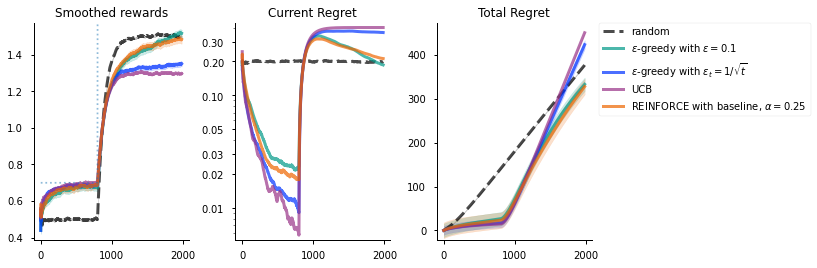

In [18]:
experiment3.show()

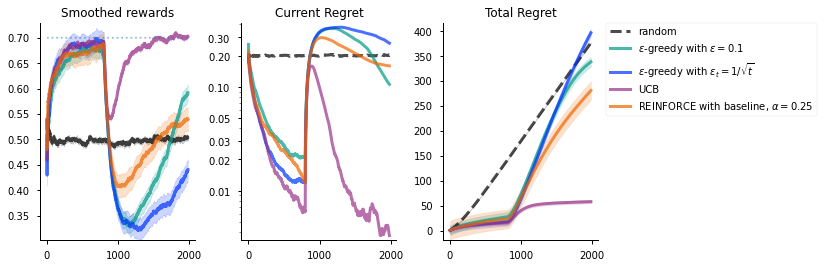

In [19]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[8 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> At the 800 step point, the reward and failure actions are, in essence, flipped with previous bad actions, now yielding the greatest reward, with the reward for success remaining constant. The best algorithms for dealing with this approach are REINFORCE and $\epsilon$-greedy=0.1 as both approaches continue to select low reward actions, using probability, later in training, leading to selecting the new high reward actions and updating accordingly.  $\epsilon$-greedy=$1/\sqrt t$ and UCB will continue to select the non-optimal actions as by this point, epsilon will be small due to decay, and the upper confidence bound will be narrow given the actions have already been selected a large number of times, with the reward remaining constant for selecting the previously rewarded actions. 

**[8 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> Here UCB performs markedly better (explained in the next question), adjusting to the change in rewards very quickly, with $\epsilon$-greedy with $\epsilon=0.1$ also performing well given it will continue to explore lower predicted reward actions and update to the new rewards. REINFORCE with baseline does not improve as quickly as $\epsilon=0.1$, most likely due to the running average slowing the rate of updates, but given a longer timeframe, we would expect REINFORCE to identify rewarding actions and update its policy. $\epsilon$-greedy with $\epsilon=1/ \sqrt t$ performs better in experiment 4 as the Q values will decrease for the highly exploited previously rewarding actions, leading to the point where it begins to select and exploit the new rewarding actions.

**[4 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> UCB in experiment 3 has very little reason to select the previous failure actions as it has high confidence in its predicted rewards and is still rewarded for selecting the same actions as before. It will take a considerably long time for UCB to select the previous low reward actions and update the point where the predicted rewards are higher than those currently exploited. In experiment 4, the expected rewards for selecting the same actions are decreased quickly, meaning the cross-over point where the new high reward actions are selected and exploited occurs much earlier.

**[4 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

> A simple approach uses a constant step-size parameter (rather than decaying action count), giving more weight to recent rewards and enabling quick updates to the expected reward. This approach weights previously received rewards in the past exponentially less than the most recent rewards, making them less relevant to the currently expected reward. Further epsilon should be some non-zero (probably greater than 0.1) value to encourage exploration in search of updated rewards at all points in training.

**[8 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> UCB can be improved in the non-stationary environment by discounting the actions taken (Discounted-USB), giving more weight to the actions taken recently. This approach means that upper bound term quickly 'forgets' it has taken the action many times in the past, enabling it adjust quickly to enivoroment changes. This can be expressed as below, where ${1}_{[A_t = a]}$ is the indicator function, which is 1 when the action selected at time step $t$ is action a. 
$$
  A_t = \max_{a \in A}{(Q(s, a) + 
  c \sqrt{\frac{\log{(t_{\gamma})}}{N_a(\gamma, t)}} )}
$$
$$
  N_a(\gamma, t) = \sum_{s=1}^t \gamma^{t-s} {1}_{[A_t = a]}
$$
$$
  t_{\gamma} = \sum_{s=1}^t \gamma^{t-s}
$$

# C) Reasoning about algorithms

## Q8

Consider the UCB algorithm. Suppose we have two actions, $a$ and $b$. Consider the initial exploration bonus for each to be infinite, as long as we have not selected the corresponding action, so that the algorithm first selects each action at least once.

Suppose action $a$ yields a Bernoulli random reward with $p(R=1 \mid a) = 1/3$ and $p(R=0 \mid a) = 2/3$.  Action $b$ also yields a Bernoulli random reward, but with $p(R=1 \mid b) = 2/3$ and $p(R=0 \mid b) = 1/3$.

**[7 pts]** What is the probability (before seeing any data) of selecting action $a$ on the third time step (at which point we will have selected both $a$ and $b$ exactly once)?  (Break ties uniformly, if relevant.)

> We have that:
$$
p(R=1 \mid a) = 1/3
$$
$$
p(R=0 \mid a) = 2/3
$$ 
$$
p(R=1 \mid b) = 2/3
$$
$$
p(R=0 \mid b) = 1/3
$$
And that the action a will be selected on the third time step if the reward from a on the first time step is greater than the reward from b on the 2nd time step:
$$
  R_a > R_b
$$
Further, if both actions are updated using the same update rate, then when both actions produce the same reward, we will have a tie as we will have equal value estimates for both actions and the same uncertainty in the action estimate. Thus we will break ties uniformly, selecting either with 1/2 probability. This means that when $R_a = R_b$, we have a 1/2 probability of selecting action a on the third time step. Combining this, we can evaluate the likelihood of selecting a on the third time step.
$$
  p(A_3 = a) = \frac{P(R_a > R_b) + 1/2 p(R_a = R_b)}
  {P(R_a > R_b) + p(R_a = R_b) + P(R_a < R_b)}
$$
$$
= \frac{p(R=1 \mid a) \cdot p(R=0\mid b) + 
  1/2 \left( p(R=1 \mid a) \cdot p(R=1 \mid b) + 
  p(R=0 \mid a) \cdot p(R=0 \mid b) \right) }
  {p(R=1 \mid a) \cdot p(R=0\mid b) + 
  p(R=1 \mid a) \cdot p(R=1 \mid b) + 
  p(R=0 \mid a) \cdot p(R=0 \mid b) +
  p(R=0 \mid a) \cdot p(R=1 \mid b)
   }
$$
$$
= \frac{p(R=1 \mid a) \cdot p(R=0\mid b) + 
  1/2 \left( p(R=1 \mid a) \cdot p(R=1 \mid b) + 
  p(R=0 \mid a) \cdot p(R=0 \mid b) \right) }
  {p(R=1 \mid a) \cdot p(R=0\mid b) + 
  p(R=1 \mid a) \cdot p(R=1 \mid b) + 
  p(R=0 \mid a) \cdot p(R=0 \mid b) +
  p(R=0 \mid a) \cdot p(R=1 \mid b)
   }
$$
$$
= \frac{ \frac{1}{3} \cdot \frac{1}{3} + 
  \frac{1}{2} \left( \frac{1}{3} \cdot \frac{2}{3} + 
  \frac{2}{3} \cdot \frac{1}{3} \right) }
  { \frac{1}{3} \cdot \frac{1}{3} + 
  \frac{1}{3} \cdot \frac{2}{3} + 
  \frac{2}{3} \cdot \frac{1}{3}+
  \frac{2}{3} \cdot \frac{2}{3}
   }
$$
$$
= \frac{ \frac{1}{9} + \frac{1}{2} \left( \frac{4}{9} \right) }
  { 1}
  = \frac{1}{9} + \frac{2}{9}
$$
Thus,
$$
  p(A_3 = a) = 1/3
$$

## Q9

Consider a bandit with two arms, $a$ and $b$.  So far, we have seen the following actions and rewards, on time steps $t=1$ and $t=2$:
\begin{align*}
t=1\,:\qquad A_1=a~,~ R_1=0\\
t=2\,:\qquad A_2=b~,~ R_2=1 
\end{align*}
The rewards are known to be Bernoulli random variables (so $R_t \in \{0, 1\}$) with unknown means.

Consider a Thompson sampling algorithm to select actions, with a uniform Beta prior at time $t=0$ such that the probability density functions for the expected reward for both actions before seeing any data (at time $t=0$) are defined by $p(E[R] = x\mid a) = 1$, for all $x\in[0,1]$, and all $a$.


**[7 pts]** What is the probability under Thompson sampling of $A_3 = a$? Show your calculations, but keep it concise.

> The Beta prior probability density function is given by: 
$$
  p(x_k) = \frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k) \Gamma(\beta_k)} x^{\alpha_k -1}(1-x_k)^{\beta_k -1}
$$
Where, 
$$
  \Gamma(n) = (n-1)!
$$
Where $\alpha-1$ is the number of successes for a given action $k$, and $\beta-1$ is the number of failiures of action $k$. Both $\alpha$ and $\beta$ are initialised to 1. $x_k$ can be interpreted as the probability of reward for action $k$. 
Thus for action a and reward 0 ($\alpha=1, \beta=2$),  
$$
  P(X_a = x_a) = \frac{\Gamma(3)}{\Gamma(1) \Gamma(2)} \cdot (1-x_a)
$$
$$
  P(X_a = x_a) = \frac{2}{1} \cdot (1-x_a) = 2 \cdot (1-x_a)
$$
And for action b and reward 1 ($\alpha=2, \beta=1$), 
$$
  P(X_b = x_b) = \frac{\Gamma(3)}{\Gamma(2) \Gamma(1)} \cdot x_b
$$
$$
  P(X_b = x_b) = \frac{2}{1} \cdot x_b= 2 \cdot x_b
$$
We are looking for the probability that $P(X_a > X_b)$ for the two actions with the beta distributions defined above. Thus we can express this as an double intergral using the indicator function for $I[X_a > X_b]$. Thus,
$$
  P(X_a > X_b) = \int_0^1 \int_0^1 P(X_a = x_a) P(X_b = x_b) I[x_a > x_b] dx_b dx_a
$$
Where thr indicator is 0 when $x_a \ne x_b$, thus we can remove all cases when it is zero,
$$
  P(X_a > X_b) = \int_0^1 \int_0^{x_a} P(X_a = x_a) P(X_b = x_b) dx_b dx_a
$$
Plugging in the values derived above gives,
$$
  P(X_a > X_b) = \int_0^1 \int_0^{x_a} 4 \cdot (1-x_a) \cdot x_b dx_b dx_a
$$
$$
  P(X_a > X_b) = \int_0^1 2 \cdot (1-x_a) \cdot x_a^2 dx_a = 
  \int_0^1 2 \cdot (x_a^2 - x_a^3) dx_a 
$$
$$
  P(X_a > X_b) = 2 \cdot  (\frac{1}{3} - \frac{1}{4}) = \frac{1}{6} = 0.166
$$
Therefore the probability of selecting action a on time step 3 is 0.166.



## Q10

Consider a tabular ergodic MDP, and consider the following algorithm: 

On each time step $t$ we use UCB in the state we are currently in to determine the action to take.  Specifically, use and update the required statistics for UCB locally, for that state. In other words, in each state we update the UCB statistics as if that state is a bandit problem. 

However, instead of averaging the immediate rewards to use as action values, we use one-step Q-learning with a step size $\alpha_t$ to predict action values with some discount $\gamma \in [0, 1]$.

**[8 pts]** Is this algorithm guaranteed to converge to the optimal value function $q_*$ (for any finite MDP with well-defined values, e.g., $\gamma<1$) for an appropriately chosen step size schedule $\{ \alpha_t \}_{t=0}^\infty$?  Prove your answer, but be concise.  (E.g., this proof should not include lengthy calculations, you don't have to specify a concrete step size schedule, etc.)

> We have $Q'(s_t,a_t)$ as the updated Q value for state, $s_t$, and action $a_t$, and $Q(s_t,a_t)$ the origninal value. $\max_{a \in A}(Q(s_{t+1}, A_{t+1}))$ is the estimate of the optimal future value, which is discounted by the discount factor $\gamma$. This results in an update rule,
$$
  Q'(s_t,a_t) := Q(s_t,a_t) + \alpha \cdot [ r_t + \gamma \cdot \max_{a \in A}(Q(s_{t+1}, A_{t+1})) - Q(s_t,a_t)]
$$
We know that Q-learning is guaranteed to convergence to the optimal value function $q^*$ if each action-state value is updated infinitely many times using any policy, so long as $\sum_t \alpha_t = \infty$ and $\sum_t \alpha_t^2 < \infty$. Thus, if we select $\alpha$ to be some value inversely proportional to t, e.g. $\alpha = 1/ t^2$, then if each action-state value is updated infinitely many times, we are guaranteed to converge in a finite MDP. 
We also know that the action is selected at state, s, using UCB,
$$
  a_t = \max_{a \in A}{ [( Q(s_t, a_t)) + c \sqrt{\frac{\ln(t)}{N_a}}} ]
$$
Assuming the problem is stationary and $c > 0$, UCB guarantees that as $t \to \infty$ each action at each state is selected infinitely many times, thus ensuring convergence of $Q \to q^*$. Higher $Q(s_t, a_t)$ values would be selected far more often than low values, but given an infinite series, we would still expect every state-action pair to be selected infinitely many times. \\
We can see that each action would be selected infinitely many times when considering that as $t \to \infty$, $\ln{(t)} \to \infty$, thus in order for the upper bound to remain finite, $N_a \to \infty$. This further condition is all we need to guarantee convergence, assuming $Q(s, a) < \infty \space \forall s, a$.  